In [1]:
!pip install tensorflow
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

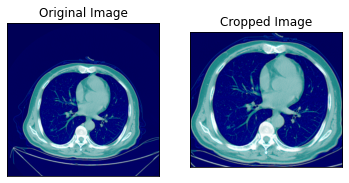

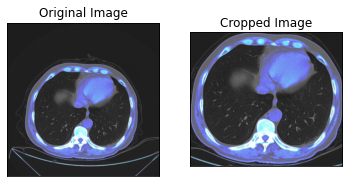

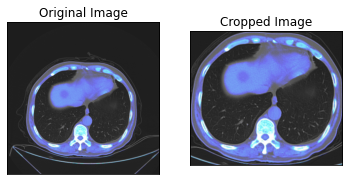

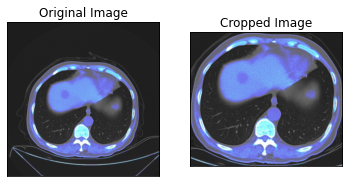

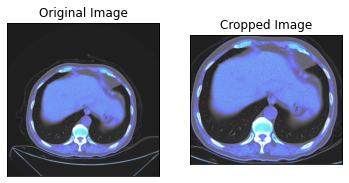

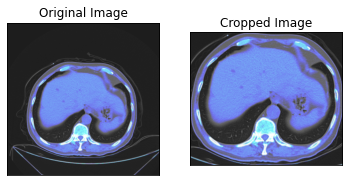

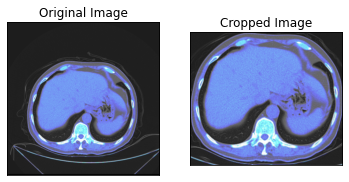

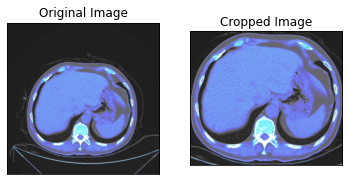

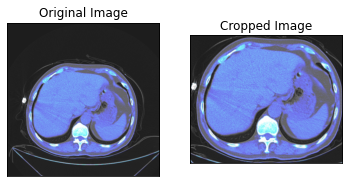

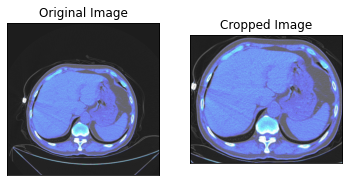

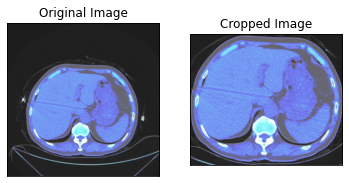

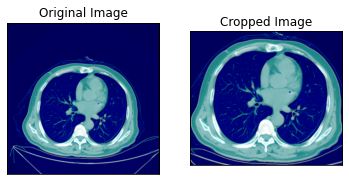

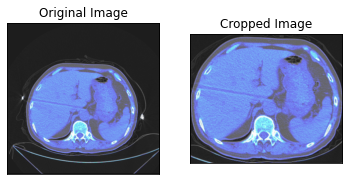

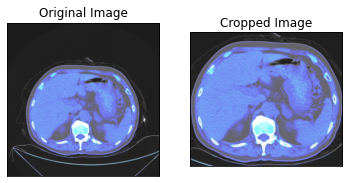

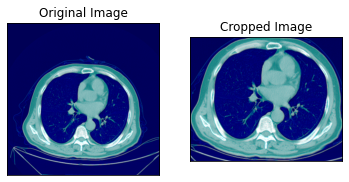

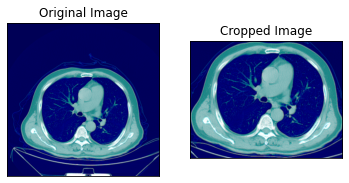

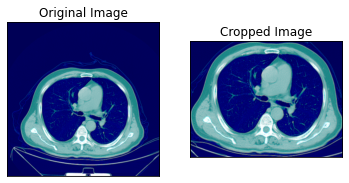

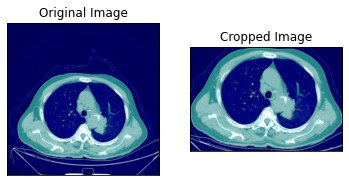

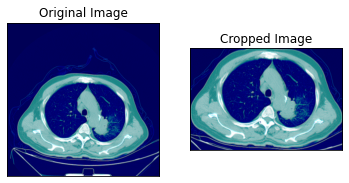

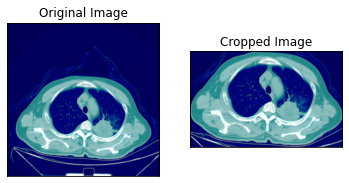

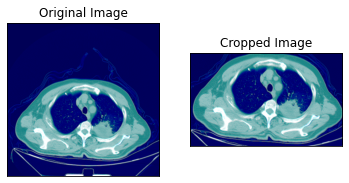

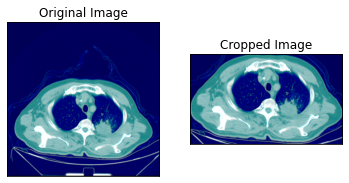

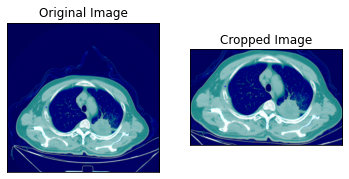

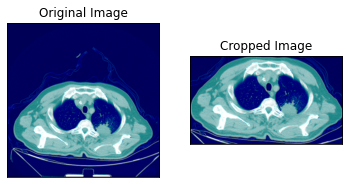

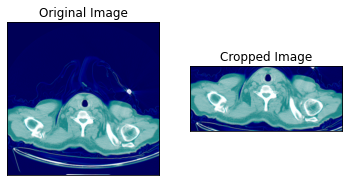

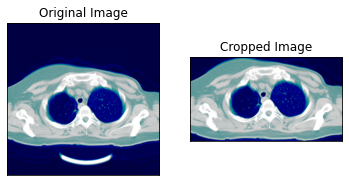

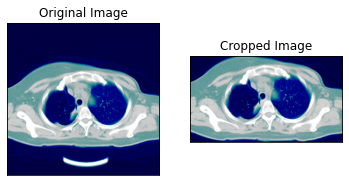

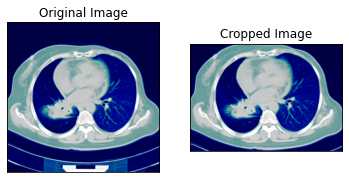

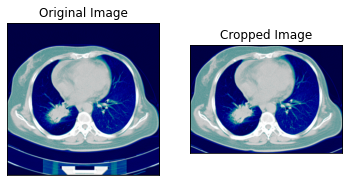

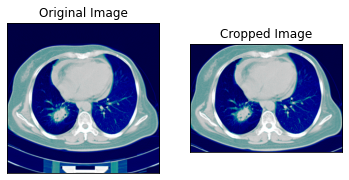

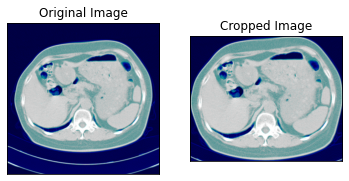

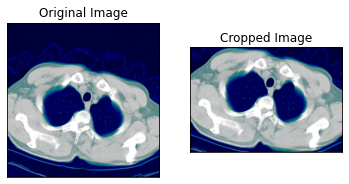

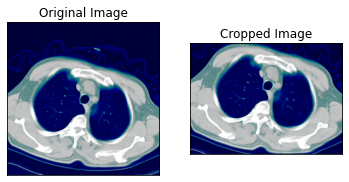

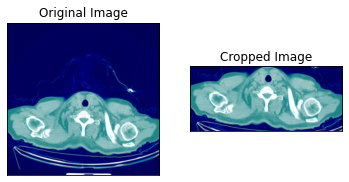

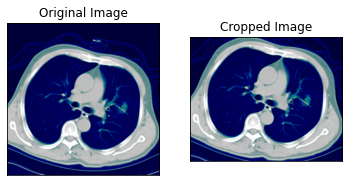

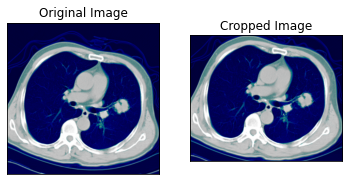

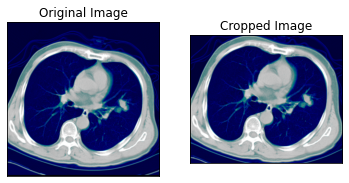

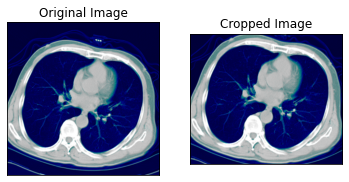

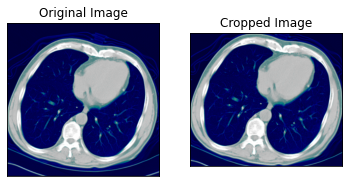

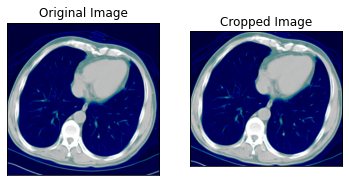

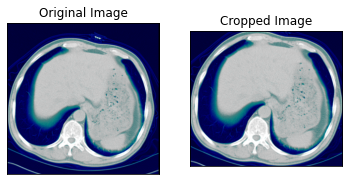

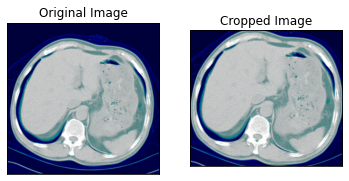

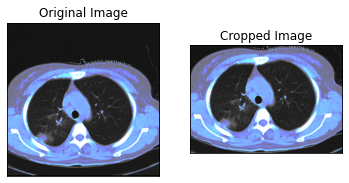

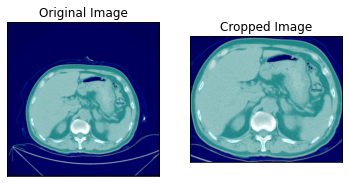

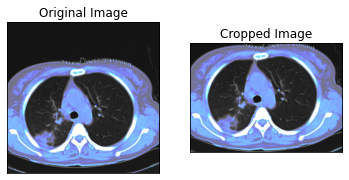

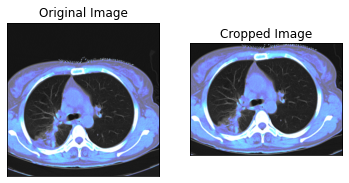

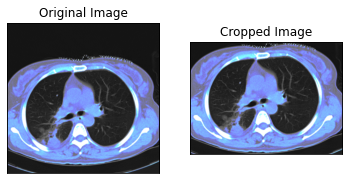

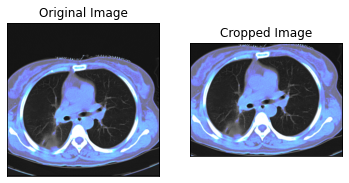

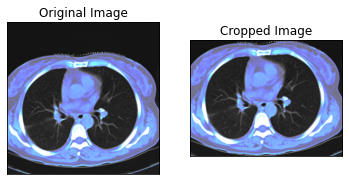

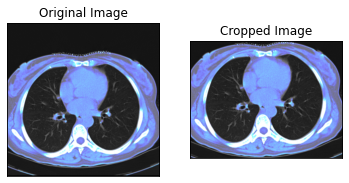

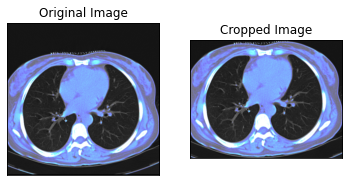

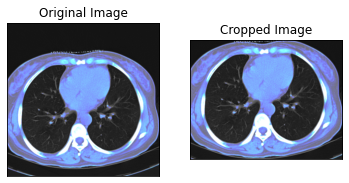

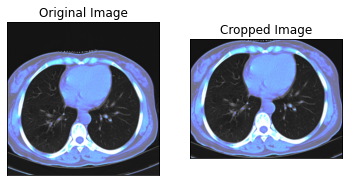

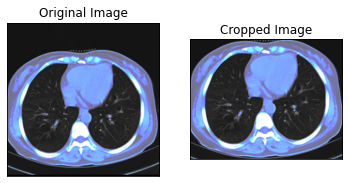

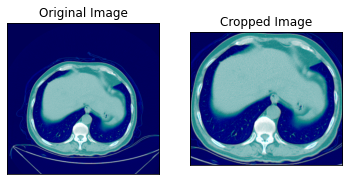

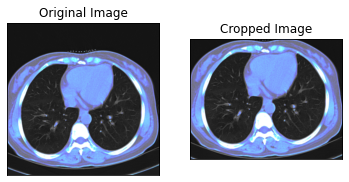

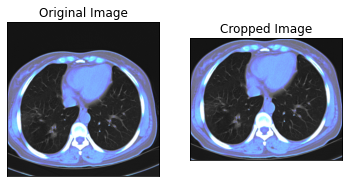

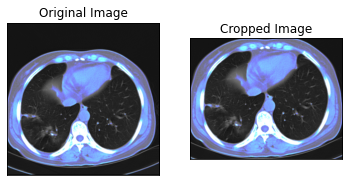

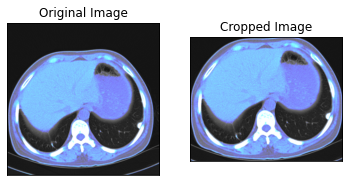

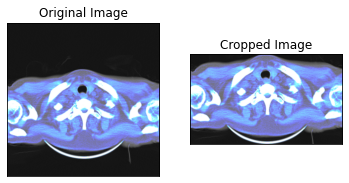

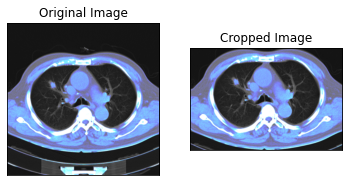

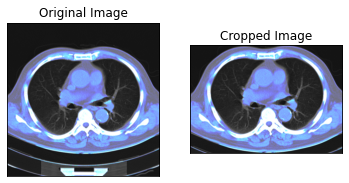

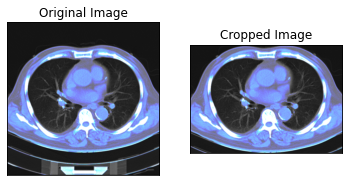

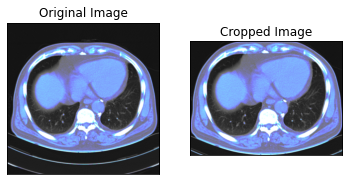

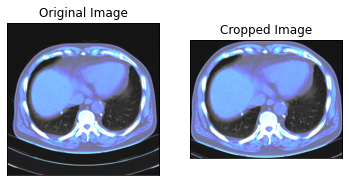

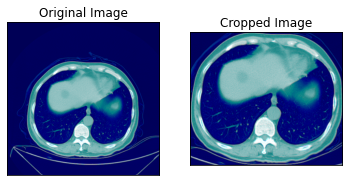

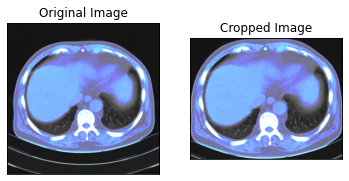

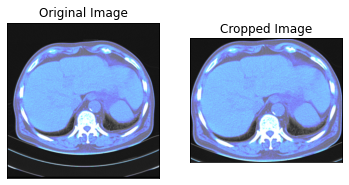

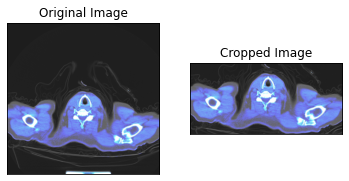

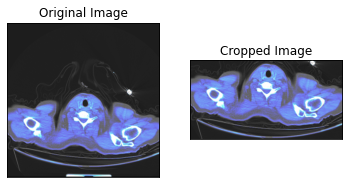

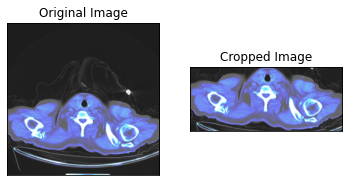

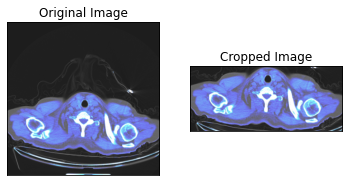

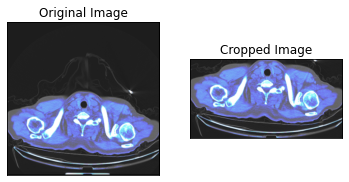

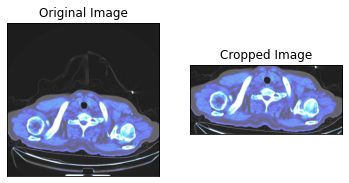

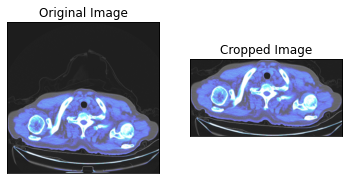

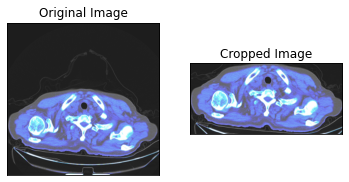

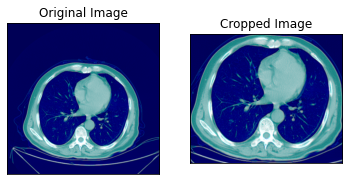

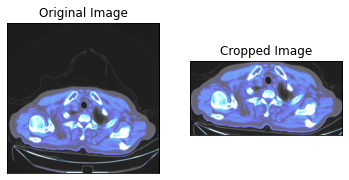

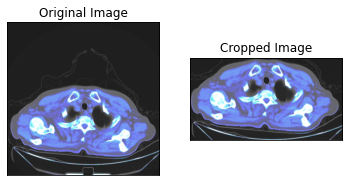

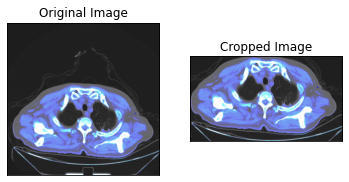

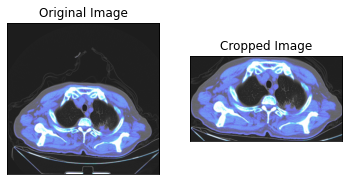

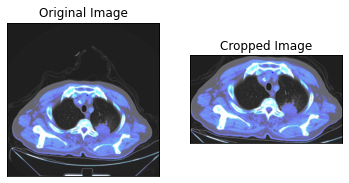

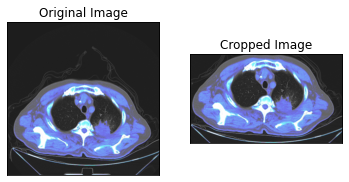

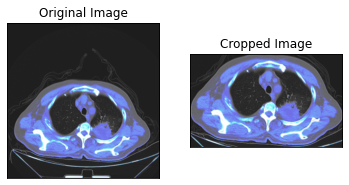

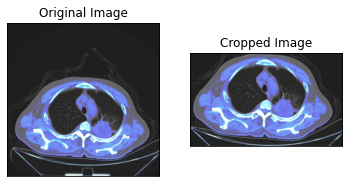

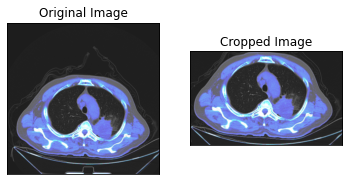

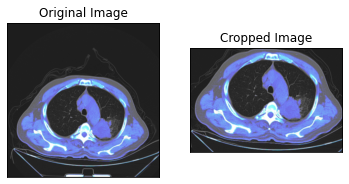

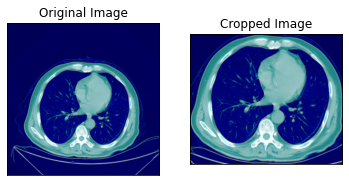

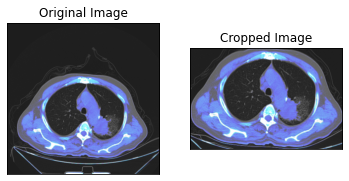

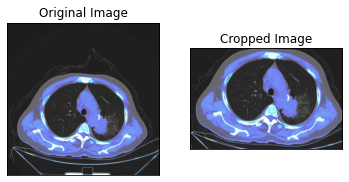

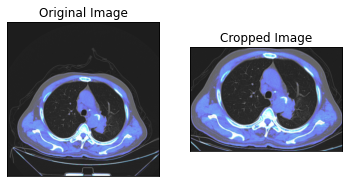

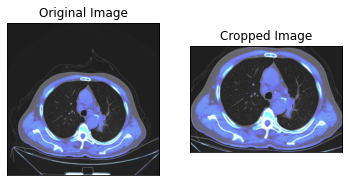

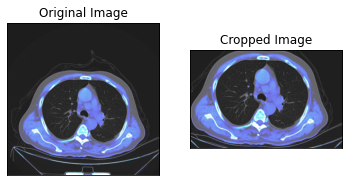

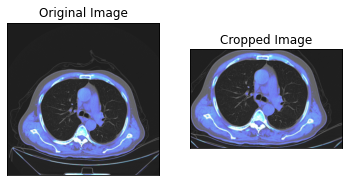

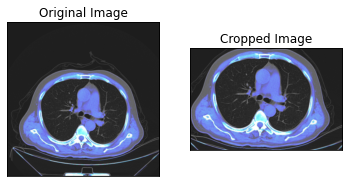

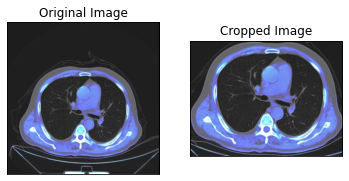

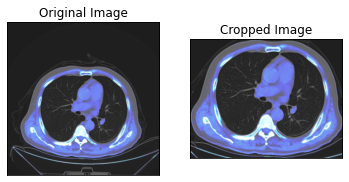

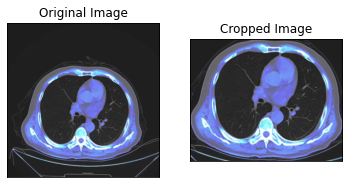

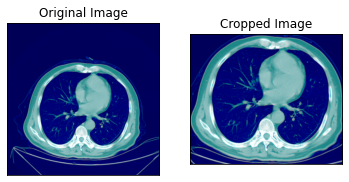

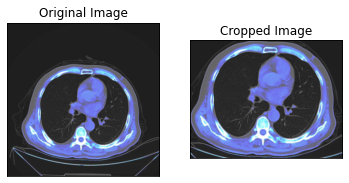

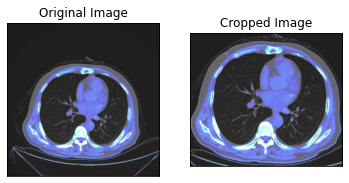

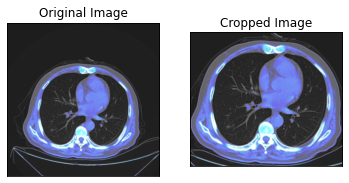

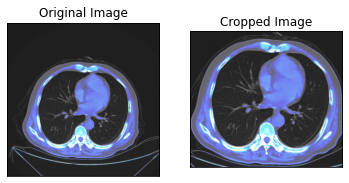

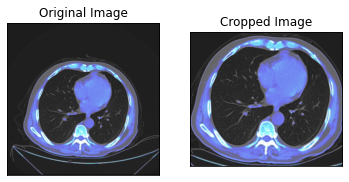

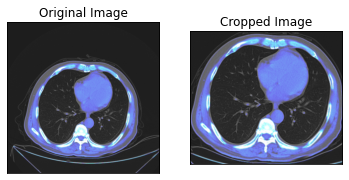

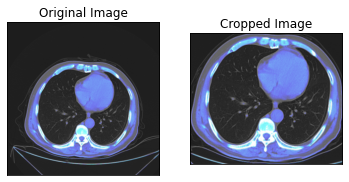

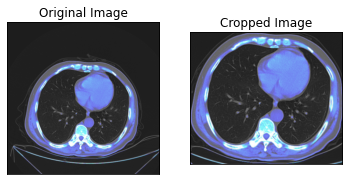

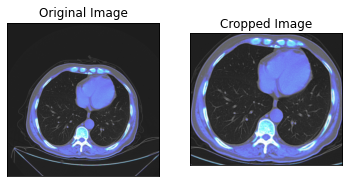

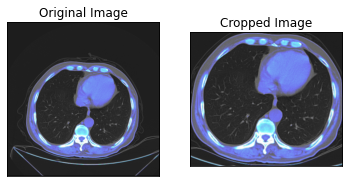

In [2]:
!pip install opencv-python

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def crop_lung_contour(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

def process_images(path):
    # Create subfolder named "Cropped_fusedByCode"
    subfolder = os.path.join(path, "Cropped_fusedByCode")
    os.makedirs(subfolder, exist_ok=True)

    # Loop through each image file in the specified path
    for file in os.listdir(path):
        if file.endswith('.png') or file.endswith('.jpg'):
            # Read the image file
            image = cv2.imread(os.path.join(path, file))

            # Call the crop_lung_contour function on the image
            cropped_image = crop_lung_contour(image, plot=True)

            # Save the cropped image with a new file name
            new_file = 'cropped_' + file
            cv2.imwrite(os.path.join(subfolder, new_file), cropped_image)

process_images('C:/New Volume D/LUNG PROJECT/Fused-All')


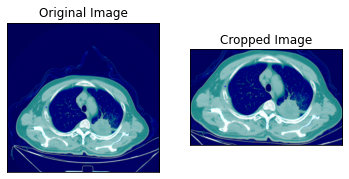

True

In [3]:
import cv2
import os

# Define the path to the image file
image_path = 'C:/New Volume D/LUNG PROJECT/Fused-All/2.png'

# Read the image
image = cv2.imread(image_path)

# Crop the lung contour
cropped_image = crop_lung_contour(image, plot=True)

# Define the path to the output file
output_path = 'C:/New Volume D/LUNG PROJECT/Fused-All/Sample_cropping/cropped_image.png'

# Save the cropped image
cv2.imwrite(output_path, cropped_image)


In [12]:
import os
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import io, color

from skimage import transform


def extract_hog_features(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize image to 64x64 pixels
    resized = transform.resize(gray, (64, 64))

    # Extract HOG features with parameters (orientations, pixels_per_cell, cells_per_block)
    features = hog(resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')

    return features



def load_dataset(path):
    # Create empty lists to store features and labels
    X, y = [], []

    # Loop through each cropped image file in the specified path for 'yes' class
    for file in os.listdir(os.path.join(path, 'yes')):
        if file.endswith('.png'):
            # Read the image file
            image = cv2.imread(os.path.join(path, 'yes', file))

            # Extract HOG features from the image
            features = extract_hog_features(image)

            # Append features and label to the lists
            X.append(features)
            y.append(1)

    # Loop through each cropped image file in the specified path for 'no' class
    for file in os.listdir(os.path.join(path, 'no')):
        if file.endswith('.png'):
            # Read the image file
            image = cv2.imread(os.path.join(path, 'no', file))

            # Extract HOG features from the image
            features = extract_hog_features(image)

            # Append features and label to the lists
            X.append(features)
            y.append(0)

    return X, y


def train_classifier(X, y):
    # Split dataset into training and testing sets with 80% for training and 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a support vector machine classifier with a radial basis function kernel
    clf = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
    clf.fit(X_train, y_train)

    # Predict labels for test set
    y_pred = clf.predict(X_test)

    # Print accuracy score
    print("Accuracy:", accuracy_score(y_test, y_pred))

    return clf

def detect_lung_cancer(path, clf):
    # Loop through each image file in the specified path
    for file in os.listdir(path):
        if file.endswith('.png'):
            # Read the image file
            image = io.imread(os.path.join(path, file))

            # Extract HOG features from the image
            features = extract_hog_features(image)

            # Predict label for the image
            prob = clf.predict_proba([features])[0][1]

            # Print prediction result and probability
            print(file, 'Cancer Probability:', prob)

# Path to the folder containing the lung images
path = 'C:/New Volume D/LUNG PROJECT/Fused-All'

# Load dataset
X, y = load_dataset(path)

# Train classifier
clf = train_classifier(X, y)

# Detect lung cancer
detect_lung_cancer(path, clf)


Accuracy: 0.9545454545454546
10.png Cancer Probability: 0.1705495677830071
100.png Cancer Probability: 0.22081999628442808
101.png Cancer Probability: 0.23297383561888185
102.png Cancer Probability: 0.27949122271647986
103.png Cancer Probability: 0.12124263295540212
104.png Cancer Probability: 0.10165376174619184
105.png Cancer Probability: 0.0925403468503775
106.png Cancer Probability: 0.12449643095440358
107.png Cancer Probability: 0.09635042701841796
108.png Cancer Probability: 0.10839954838496314
109.png Cancer Probability: 0.09542958120080548
11.png Cancer Probability: 0.16548823386071118
110.png Cancer Probability: 0.10638703198524856
111.png Cancer Probability: 0.08377032940799997
12.png Cancer Probability: 0.17620255973471546
13.png Cancer Probability: 0.14178987301819546
14.png Cancer Probability: 0.12623240987360546
15.png Cancer Probability: 0.13745900220707957
16.png Cancer Probability: 0.13232536760434924
17.png Cancer Probability: 0.11297456098987463
18.png Cancer Probabi

In [39]:
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator

def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Augments lung cancer images with additional augmentations and preprocessing.

    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: An integer representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """
    
    if not os.path.exists(file_dir):
        raise ValueError("The input directory does not exist.")
        
    if not n_generated_samples.isdigit():
        raise ValueError("The number of generated samples must be an integer.")
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  zoom_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )
    
    for filename in os.listdir(file_dir):
        # load the image
        image = cv2.imread(os.path.join(file_dir, filename), cv2.IMREAD_COLOR)
        
        # resize the image to a consistent size
        resized_image = cv2.resize(image, (256, 256))
        
        # apply normalization if desired
        # normalized_image = (resized_image - np.mean(resized_image)) / np.std(resized_image)
        
        # reshape the image
        image_3d = resized_image.reshape(resized_image.shape + (1,))
        image_3d = np.squeeze(image_3d, axis=-1)

        image_4d = image_3d.reshape((1,) + image_3d.shape)
        
        # prefix of the names for the generated samples
        save_prefix = 'aug_' + filename[:-4]
        
        # generate 'n_generated_samples' sample images
        i = 0
        for batch in data_gen.flow(x=image_4d, batch_size=1, save_to_dir=save_to_dir, 
                                   save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > int(n_generated_samples):
                break


In [29]:
augment_data('C:/New Volume D/LUNG PROJECT/Fused-All', '10', 'C:/New Volume D/LUNG PROJECT/Fused-All/Cropped_fusedByCode/Images_by_augmenting')

# The below error can be ignored

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [42]:
file_dir = 'C:/New Volume D/LUNG PROJECT/Fused-All'

start_time = time.time()

augmented_data_path = 'C:/New Volume D/LUNG PROJECT/Fused-All/Cropped_fusedByCode/Images_by_augmenting'

# augment data for the examples with label equal to 'yes' representing tumorous examples
augment_data(file_dir='YES/', n_generated_samples=6, save_to_dir=augmented_data_path+'yes/')
# augment data for the examples with label equal to 'no' representing non-tumorous examples
augment_data(file_dir='NO/', n_generated_samples=9, save_to_dir=augmented_data_path+'no/')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


ValueError: The input directory does not exist.

In [ ]:
def data_summary(main_path):
    
    yes_path = main_path+'yes/'
    no_path = main_path+'no/'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(os.listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(os.listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 


In [30]:
import cv2

# Load the image
img = cv2.imread("C:/New Volume D/LUNG PROJECT/Fused-All/Cropped_fusedByCode")

# Check if the image was read correctly
if img is None:
    print("Error: Could not read image file")
else:
    # Check the shape of the image
    print("Image shape:", img.shape)

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height))

    # Display the resized image
    cv2.imshow("Resized image", resized_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Error: Could not read image file


In [8]:
import os

# Set up paths to YES and NO directories
yes_dir = "C:/New Volume D/LUNG PROJECT/Fused-All/YES/YES_byCODE"
no_dir = "C:/New Volume D/LUNG PROJECT/Fused-All/NO/NO_byCODE"

# Create YES and NO directories if they don't exist
if not os.path.exists(yes_dir):
    os.makedirs(yes_dir)
if not os.path.exists(no_dir):
    os.makedirs(no_dir)


In [14]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Set up paths to YES and NO image directories
yes_dir = "C:/New Volume D/LUNG PROJECT/Fused-All/YES"
no_dir = "C:/New Volume D/LUNG PROJECT/Fused-All/NO"

# Define function to read and preprocess images
def read_and_preprocess_image(file_path):
    with Image.open(file_path) as image:
        # Resize the image to (224, 224) if necessary
        if image.size != (224, 224):
            image = image.resize((224, 224))
        # Convert the image to a numpy array
        image_array = np.array(image)
        # Normalize the image values to be between 0 and 1
        normalized_image_array = image_array / 255.0
    return normalized_image_array

# Collect and organize labeled images into separate folders
X = []
y = []
for image_file in os.listdir(yes_dir):
    if image_file.endswith(".png"):
        image_path = os.path.join(yes_dir, image_file)
        X.append(read_and_preprocess_image(image_path))
        y.append(1)
for image_file in os.listdir(no_dir):
    if image_file.endswith(".png"):
        image_path = os.path.join(no_dir, image_file)
        X.append(read_and_preprocess_image(image_path))
        y.append(0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

# Convert the data to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
